In [4]:
!pip install wordcloud 

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 161.1/161.1 kB 2.7 MB/s eta 0:00:00a 0:00:01


In [5]:
#Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from textblob import TextBlob
from nltk.stem import PorterStemmer
from textblob import Word
from sklearn import model_selection, preprocessing, linear_model, metrics
from sklearn.linear_model import LogisticRegression
import seaborn as sns
import nltk
import re
from bs4 import BeautifulSoup
from wordcloud import WordCloud
import os

In [7]:
#import data: sourced from kaggle
data = pd.read_csv('consumer_complaints.csv', encoding='latin-1')
data.head()

/var/folders/wj/_0sxv10d2yv0s5t24sjf71680000gn/T/ipykernel_15741/1705297428.py:2: DtypeWarning: Columns (5,11) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('consumer_complaints.csv', encoding='latin-1')


,date_received,product,sub_product,issue,sub_issue,consumer_complaint_narrative,company_public_response,company,state,zipcode,tags,consumer_consent_provided,submitted_via,date_sent_to_company,company_response_to_consumer,timely_response,consumer_disputed?,complaint_id
0,08/30/2013,Mortgage,Other mortgage,"Loan modification,collection,foreclosure",NaN,NaN,NaN,U.S. Bancorp,CA,95993,NaN,NaN,Referral,09/03/2013,Closed with explanation,Yes,Yes,511074
1,08/30/2013,Mortgage,Other mortgage,"Loan servicing, payments, escrow account",NaN,NaN,NaN,Wells Fargo & Company,CA,91104,NaN,NaN,Referral,09/03/2013,Closed with explanation,Yes,Yes,511080
2,08/30/2013,Credit reporting,NaN,Incorrect information on credit report,Account status,NaN,NaN,Wells Fargo & Company,NY,11764,NaN,NaN,Postal mail,09/18/2013,Closed with explanation,Yes,No,510473
3,08/30/2013,Student loan,Non-federal student loan,Repaying your loan,Repaying your loan,NaN,NaN,"Navient Solutions, Inc.",MD,21402,NaN,NaN,Email,08/30/2013,Closed with explanation,Yes,Yes,510326
4,08/30/2013,Debt collection,Credit card,False statements or representation,Attempted to collect wrong amount,NaN,NaN,Resurgent Capital Services L.P.,GA,30106,NaN,NaN,Web,08/30/2013,Closed with explanation,Yes,Yes,511067


In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 555957 entries, 0 to 555956
Data columns (total 18 columns):
 #   Column                        Non-Null Count   Dtype 
---  ------                        --------------   ----- 
 0   date_received                 555957 non-null  object
 1   product                       555957 non-null  object
 2   sub_product                   397635 non-null  object
 3   issue                         555957 non-null  object
 4   sub_issue                     212622 non-null  object
 5   consumer_complaint_narrative  66806 non-null   object
 6   company_public_response       85124 non-null   object
 7   company                       555957 non-null  object
 8   state                         551070 non-null  object
 9   zipcode                       551452 non-null  object
 10  tags                          77959 non-null   object
 11  consumer_consent_provided     123458 non-null  object
 12  submitted_via                 555957 non-null  object
 13 

In [9]:
#selecting needed columns
data = data[['product', 'consumer_complaint_narrative']]
data.head()

,product,consumer_complaint_narrative
0,Mortgage,NaN
1,Mortgage,NaN
2,Credit reporting,NaN
3,Student loan,NaN
4,Debt collection,NaN


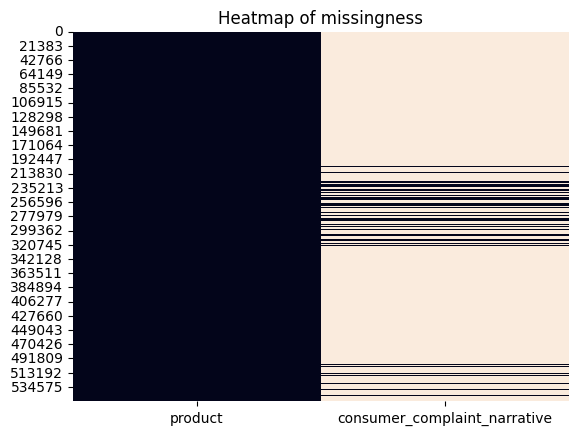

In [10]:
#missing heat map
sns.heatmap(data.isnull(), cbar=False)
plt.title('Heatmap of missingness')
plt.show()

In [11]:
np.sum(data.isnull())

product                              0
consumer_complaint_narrative    489151
dtype: int64

In [12]:
#remove na from consumer_complaint_narrative 
data = data[pd.notnull(data['consumer_complaint_narrative'])]

In [13]:
np.sum(data.isnull())

product                         0
consumer_complaint_narrative    0
dtype: int64

In [14]:
data.head()

,product,consumer_complaint_narrative
190126,Debt collection,XXXX has claimed I owe them {$27.00} for XXXX ...
190135,Consumer Loan,Due to inconsistencies in the amount owed that...
190155,Mortgage,In XX/XX/XXXX my wages that I earned at my job...
190207,Mortgage,I have an open and current mortgage with Chase...
190208,Mortgage,XXXX was submitted XX/XX/XXXX. At the time I s...


In [15]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 66806 entries, 190126 to 553096
Data columns (total 2 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   product                       66806 non-null  object
 1   consumer_complaint_narrative  66806 non-null  object
dtypes: object(2)
memory usage: 1.5+ MB


In [16]:
#factorize product column into categories
data['category_id'] = data['product'].factorize()[0]
data.head()

,product,consumer_complaint_narrative,category_id
190126,Debt collection,XXXX has claimed I owe them {$27.00} for XXXX ...,0
190135,Consumer Loan,Due to inconsistencies in the amount owed that...,1
190155,Mortgage,In XX/XX/XXXX my wages that I earned at my job...,2
190207,Mortgage,I have an open and current mortgage with Chase...,2
190208,Mortgage,XXXX was submitted XX/XX/XXXX. At the time I s...,2


In [17]:
data['category_id'].nunique()

11

In [18]:
data.groupby('product').count()

,consumer_complaint_narrative,category_id
product,,
Bank account or service,5711,5711
Consumer Loan,3678,3678
Credit card,7929,7929
Credit reporting,12526,12526
Debt collection,17552,17552
Money transfers,666,666
Mortgage,14919,14919
Other financial service,110,110
Payday loan,726,726


## Visualizing data distribution on pie chart


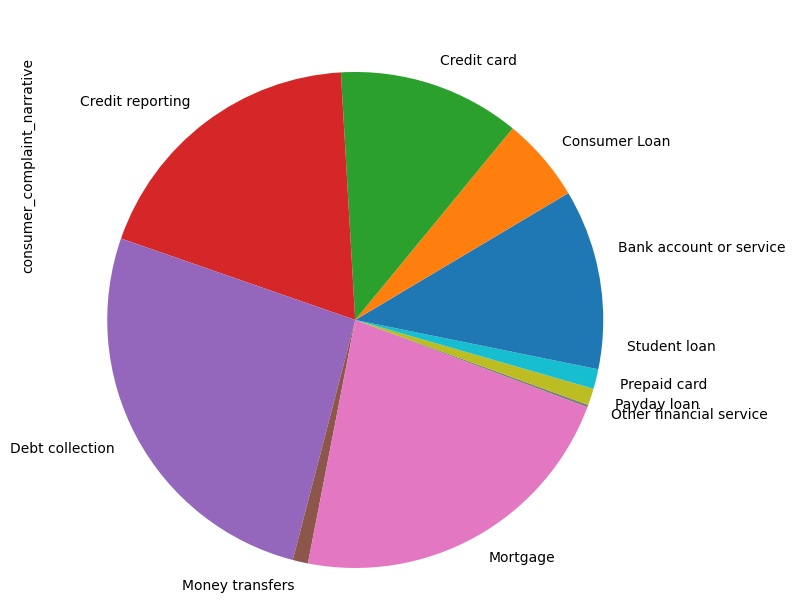

In [19]:
fig = plt.figure(figsize=(8,6))
data.groupby('product').consumer_complaint_narrative.count().plot.pie(ylim=0)
plt.show()

## Visualizing data distribution on bar plot

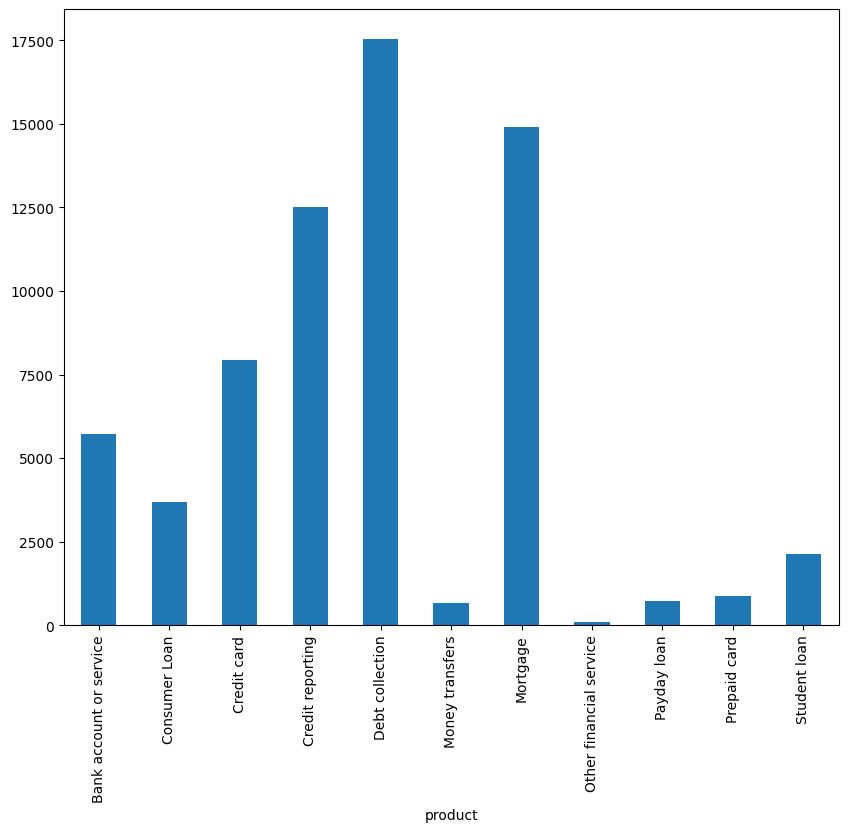

In [20]:
fig = plt.figure(figsize=(10,8))
data.groupby('product').consumer_complaint_narrative.count().plot.bar(ylim=0)
plt.show()

## Futher analysis of product using Wordcloud

In [21]:
categ = data.groupby('product').agg({"consumer_complaint_narrative": ' | '.join})

In [22]:
categ

,consumer_complaint_narrative
product,
Bank account or service,I opened an account with M & T bank online on ...
Consumer Loan,Due to inconsistencies in the amount owed that...
Credit card,i opened XXXX Bank of America credit cards 15-...
Credit reporting,Transunion # XXXXSince I received the letter f...
Debt collection,XXXX has claimed I owe them {$27.00} for XXXX ...
Money transfers,I was scammed into sending money for a XXXX bo...
Mortgage,In XX/XX/XXXX my wages that I earned at my job...
Other financial service,I started their program in XXXX of 2012. I bel...
Payday loan,I 'm receiving calls from a company who will n...


## Wordcloud analysis of credit reporting

In [23]:
#data extraction
credit_repo = categ.iloc[3,0]

In [26]:
import nltk
nltk.download('stopwords')

#preprocsessing for visualization
def review_to_words(raw_review):
    bs = BeautifulSoup(raw_review).get_text()
    letters_only = re.sub('[^a-zA-Z]', ' ', bs)
    #tokenization
    words_only = letters_only.lower().split()
    stops = set(stopwords.words('english'))
    words = [w for w in words_only if not w in stops]
    return (" ".join(words))

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ashleshkhajbage/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [27]:
clean_credit_repo = str(review_to_words(credit_repo))

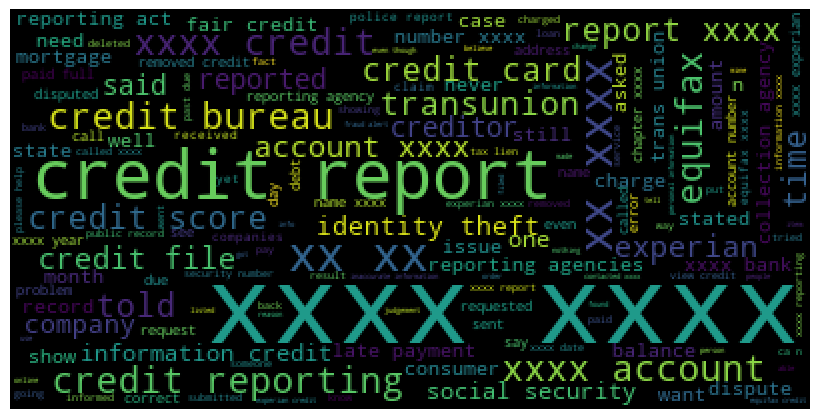

In [28]:
wordcloud = WordCloud().generate(clean_credit_repo) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

In [29]:
#re-analyzing the complains without the xxxx words
cleaned_credit_repo = clean_credit_repo.replace ('xxxx','')

In [30]:
cleaned_credit_repo = clean_credit_repo.replace ('xx','')

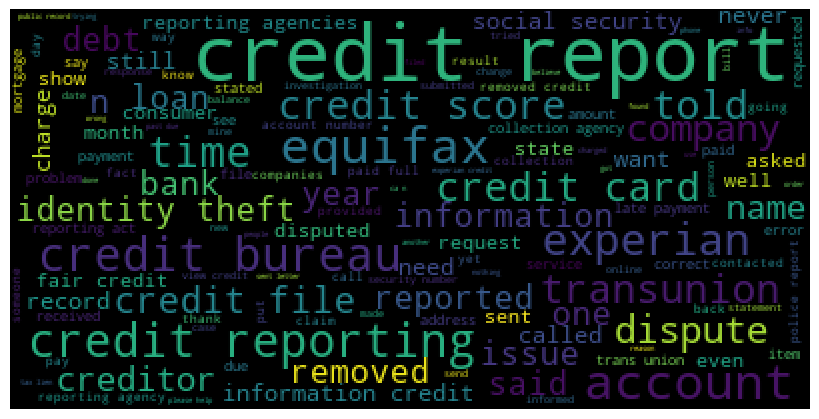

In [31]:
wordcloud = WordCloud().generate(cleaned_credit_repo) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show()

## Wordcloud analysis of Mortgage complains

In [32]:
#data extraction
mortg = categ.iloc[6,0]

In [33]:
#preprocsessing for visualization
def review_to_words(raw_review):
    bs = BeautifulSoup(raw_review).get_text()
    letters_only = re.sub('[^a-zA-Z]', ' ', bs)
    words_only = letters_only.lower().split()
    stops = set(stopwords.words('english'))
    words = [w for w in words_only if not w in stops]
    return (" ".join(words))

In [34]:
cleaned_mortg = str(review_to_words(mortg)).replace('xxxx', '').replace('xx','')


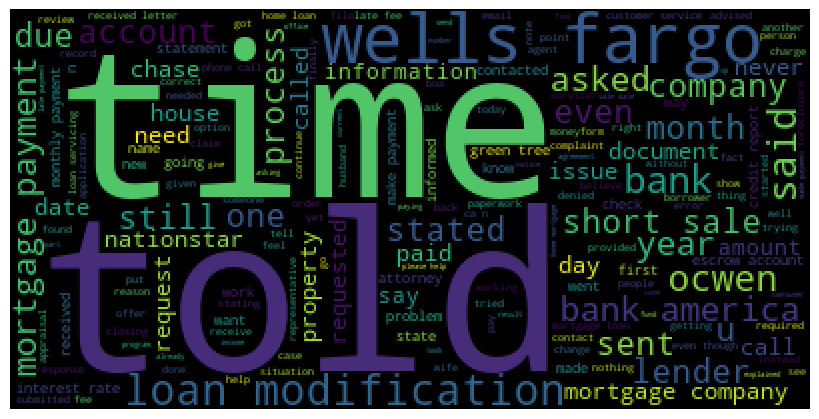

In [35]:
wordcloud = WordCloud().generate(cleaned_mortg) 
  
# plottin the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show()

## Wordcloud analysis of Debt collection complains

In [36]:
#data extraction
dc = categ.iloc[4,0]
#cleaning function for visualization
def review_to_words(raw_review):
    bs = BeautifulSoup(raw_review).get_text()
    letters_only = re.sub('[^a-zA-Z]', ' ', bs)
    words_only = letters_only.lower().split()
    stops = set(stopwords.words('english'))
    words = [w for w in words_only if not w in stops]
    return (" ".join(words))

In [37]:
#conversion to string from unicode and futher cleaning
cleaned_dc = str(review_to_words(dc)).replace('xxxx', '').replace('xx','')


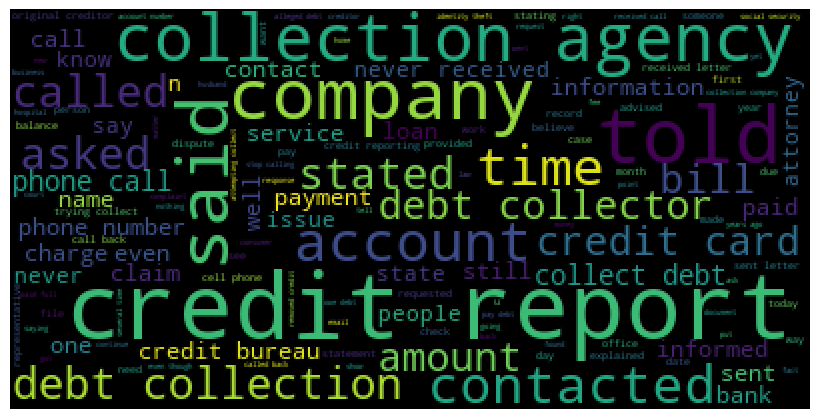

In [38]:
wordcloud = WordCloud().generate(cleaned_dc) 
  
# plottin the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show()

## Modelling

In [39]:
#splitting the data
x_train, x_test, y_train, y_test = model_selection.train_test_split(data['consumer_complaint_narrative'], data['product'])


In [40]:
#word emedding using term frequency - inverse document frequency TFIDF
encoder = preprocessing.LabelEncoder()
y_train = encoder.fit_transform(y_train)
y_test = encoder.fit_transform(y_test)

tfidf_vec = TfidfVectorizer(analyzer='word',
                           token_pattern=r'\w{1,}',
                            max_features=5000)
tfidf_vec.fit(data['consumer_complaint_narrative'])
xtrain_tfidf = tfidf_vec.transform(x_train)
xtest_tfidf = tfidf_vec.transform(x_test)

In [41]:
#modelling
model = linear_model.LogisticRegression(solver='newton-cg', 
                                        multi_class='multinomial').fit(xtrain_tfidf, 
                                                                       y_train)


In [42]:
#checking accuracy
accuracy = metrics.accuracy_score(model.predict(xtest_tfidf), y_test)
print("Accuracy: ", accuracy)

Accuracy:  0.8474434199497066


In [43]:
#classification report
print(metrics.classification_report(y_test, model.predict(xtest_tfidf), 
                                    target_names=data['product'].unique()))

                         precision    recall  f1-score   support

        Debt collection       0.83      0.80      0.81      1421
          Consumer Loan       0.82      0.59      0.69       936
               Mortgage       0.81      0.81      0.81      2009
            Credit card       0.85      0.86      0.86      3124
       Credit reporting       0.82      0.90      0.86      4410
           Student loan       0.76      0.44      0.55       169
Bank account or service       0.92      0.95      0.94      3683
            Payday loan       0.00      0.00      0.00        28
        Money transfers       0.70      0.28      0.40       178
Other financial service       0.75      0.66      0.70       199
           Prepaid card       0.92      0.75      0.83       545

               accuracy                           0.85     16702
              macro avg       0.74      0.64      0.68     16702
           weighted avg       0.84      0.85      0.84     16702



/Users/ashleshkhajbage/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ashleshkhajbage/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ashleshkhajbage/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, le

# Applying the model - 1

In [44]:
complain = ["This company refuses to provide me verification and validation of debt"
            + "per my right under the FDCPA.I do not believe this debt is mine."]

text_features = tfidf_vec.transform(complain)
predictions = model.predict(text_features)
print(complain)
print('Is predicted as: {}'.format(data.loc[data['category_id']==predictions[0], 
                                            'product'].iloc[0]))
            

['This company refuses to provide me verification and validation of debtper my right under the FDCPA.I do not believe this debt is mine.']
Is predicted as: Credit reporting


# Applying the model - 2

In [45]:
complain = ["I am writing to your company about a problem with my Hoverbike, a 2012 Skylark model. I began to have trouble staying aloft a few months ago, and this week the height control module completely failed. While the bicycle is a few months out of warranty, I believe that this occurred because of a design flaw in the Skylark, and I am asking that your company cover or share with me the cost of the required repair."]

text_features = tfidf_vec.transform(complain)
predictions = model.predict(text_features)
print(complain)
print('Is predicted as: {}'.format(data.loc[data['category_id']==predictions[0], 
                                            'product'].iloc[0]))
    

['I am writing to your company about a problem with my Hoverbike, a 2012 Skylark model. I began to have trouble staying aloft a few months ago, and this week the height control module completely failed. While the bicycle is a few months out of warranty, I believe that this occurred because of a design flaw in the Skylark, and I am asking that your company cover or share with me the cost of the required repair.']
Is predicted as: Credit reporting
